## Import Packages // Helper Functions

In [468]:
import pandas as pd, sys, re, datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

%matplotlib inline

In [469]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## (A) Data Preparation

#### Import Data & Remove Unecessary Columns

In [ ]:
# Read data
    url = "https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv"
    df = pd.read_csv(url, parse_dates = ['date_time'])
    df.drop('snow_1h', axis = 1, inplace = True)

#### Fix granularity of Dataframe

In [471]:
df['weather_description'] = df['weather_description'].str.lower()

In [472]:
# Get the repeated date_time values
rep_date = pd.DataFrame(df['date_time'].value_counts()).reset_index()
rep_date = pd.DataFrame(rep_date[rep_date['date_time'] > 1]['index'])
rep_date.rename(columns = {'index': 'date_time'}, inplace = True)

In [473]:
# To ensure concatenation of weather_main strings is done correctly, avoid duplicates
df.sort_values(by = 'weather_main', inplace = True)
df.reset_index(inplace = True, drop = True)

In [474]:
# Concatenation of weather_main and weather_description
df_rep = pd.merge(df, rep_date, how = 'inner', on = 'date_time')
df_rep_wt_main = pd.DataFrame(df_rep.groupby(df_rep.columns.difference(['weather_main', 'weather_description']).tolist())['weather_main'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()
df_rep_wt_desc = pd.DataFrame(df_rep.groupby('date_time')['weather_description'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()
df_rep = pd.merge(df_rep_wt_main, df_rep_wt_desc, how = 'inner', on = 'date_time')

In [475]:
# Remove the repeated rows of date_time
df.drop_duplicates(subset =['date_time', 'traffic_volume'], keep = False, inplace = True)

In [476]:
# Append the new cleaned rows of date_time
df = df.append(df_rep, sort = True)

#### Extract information from Dates (date_time)

In [477]:
def add_datepart(df, date_field, drop=False, time=False, errors="raise"):
    fld = df[date_field]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_field] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', date_field)
    attr = ['Month', 'Day', 'Hour', 'Date','Weekday']
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(date_field, axis=1, inplace=True)
        
add_datepart(df, 'date_time')

df['date_timeDate'] =  pd.to_datetime(df['date_timeDate'], format='%Y-%m-%d')

#### Prepare Holiday Feature

In [478]:
df_hols = df[df['holiday'] != 'None'][['holiday', 'date_timeDate']]

df = pd.merge(df, df_hols, how = 'left', on = ['date_timeDate']).drop(columns = 'holiday_x')
df.rename(columns = {'holiday_y': 'holiday'}, inplace = True)
df['holiday'].fillna('None', inplace = True)

In [479]:
df['is_Holiday'] = df['holiday'].apply(lambda x: 1 if x != 'None' else 0)

In [480]:
df_holiday = df[df['is_Holiday'] == 1][['holiday', 'date_timeDate']].drop_duplicates()

post = pd.DataFrame(df_holiday['date_timeDate'] + timedelta(days = 1))
post['prepost_holiday'] = 'Post '+ df_holiday['holiday']
post['is_prepost_hols'] = 2
pre = pd.DataFrame(df_holiday['date_timeDate'] + timedelta(days = -1))
pre['prepost_holiday'] = 'Pre '+ df_holiday['holiday']
pre['is_prepost_hols'] = 1
hols = pre.append(post, ignore_index = True)

df = pd.merge(df, hols, how = 'left', on = ['date_timeDate'])
df['prepost_holiday'].fillna('None', inplace = True)
df['is_prepost_hols'].fillna(0, inplace = True)

#### Prepare Categorical Features - to be encoded

In [481]:
df_cat = df[['date_time', 'weather_main', 'holiday']]
df_cat_encoded = pd.get_dummies(df_cat)
df = pd.merge(df, df_cat_encoded, how = 'inner', on = ['date_time'])

#### Drop Unecessary Features for final dataframe

In [482]:
df.drop(columns = ['weather_main', 'weather_description', 'holiday', 'prepost_holiday', 'date_time', 'date_timeDate'], inplace = True)

In [483]:
df.shape

(7294, 68)

In [484]:
display_all(df.head())

,clouds_all,rain_1h,temp,traffic_volume,date_timeMonth,date_timeDay,date_timeHour,date_timeWeekday,is_Holiday,is_prepost_hols,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,"weather_main_Drizzle, Fog, Mist","weather_main_Drizzle, Fog, Mist, Rain","weather_main_Drizzle, Fog, Mist, Rain, Snow","weather_main_Drizzle, Fog, Rain, Thunderstorm","weather_main_Drizzle, Haze, Mist, Rain","weather_main_Drizzle, Mist","weather_main_Drizzle, Mist, Rain","weather_main_Drizzle, Mist, Rain, Snow","weather_main_Drizzle, Mist, Snow","weather_main_Drizzle, Rain",weather_main_Fog,"weather_main_Fog, Haze","weather_main_Fog, Haze, Mist","weather_main_Fog, Haze, Mist, Rain, Snow","weather_main_Fog, Haze, Mist, Snow","weather_main_Fog, Mist","weather_main_Fog, Mist, Rain","weather_main_Fog, Mist, Rain, Snow","weather_main_Fog, Mist, Snow","weather_main_Fog, Mist, Snow, Thunderstorm","weather_main_Fog, Snow",weather_main_Haze,"weather_main_Haze, Mist","weather_main_Haze, Mist, Rain","weather_main_Haze, Mist, Rain, Snow","weather_main_Haze, Mist, Snow","weather_main_Haze, Mist, Thunderstorm","weather_main_Haze, Rain","weather_main_Haze, Rain, Snow","weather_main_Haze, Snow",weather_main_Mist,"weather_main_Mist, Rain","weather_main_Mist, Rain, Snow","weather_main_Mist, Rain, Squall, Thunderstorm","weather_main_Mist, Rain, Thunderstorm","weather_main_Mist, Snow","weather_main_Mist, Thunderstorm",weather_main_Rain,"weather_main_Rain, Snow","weather_main_Rain, Squall, Thunderstorm","weather_main_Rain, Thunderstorm",weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Memorial Day,holiday_New Years Day,holiday_None,holiday_State Fair,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washingtons Birthday
0,1,0.0,276.10,4502,3,24,15,6,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0.0,302.76,2787,8,27,21,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,8,0.0,306.79,6653,8,27,16,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,8,0.0,306.24,5883,8,27,14,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0.0,301.02,1133,8,26,23,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## (B) Modelling

In [515]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import math

In [516]:
X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']

In [517]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [518]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [520]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(7294, 67)
(4084, 67)
(2189, 67)
(1021, 67)


### Feature Selection

#### Base Model

In [527]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

/Users/khalishahnadhirah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [528]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    print('\nRoot Mean Squared Error of Predicted and Actual in on Training Set: '+ str(res[0]))
    print('Root Mean Squared Error of Predicted and Actual in Validation Set: '+ str(res[1]))
    print('R Squared score using Training Set: '+ str(res[2]))
    print('R Squared score using Validation Set: '+ str(res[3]))

In [529]:
print_score(model)

[167.90205426423708, 350.2797316034487, 0.9930380263726241, 0.9705774428639135]

Root Mean Squared Error of Predicted and Actual in on Training Set: 167.90205426423708
Root Mean Squared Error of Predicted and Actual in Validation Set: 350.2797316034487
R Squared score using Training Set: 0.9930380263726241
R Squared score using Validation Set: 0.9705774428639135


#### Correlation Analysis

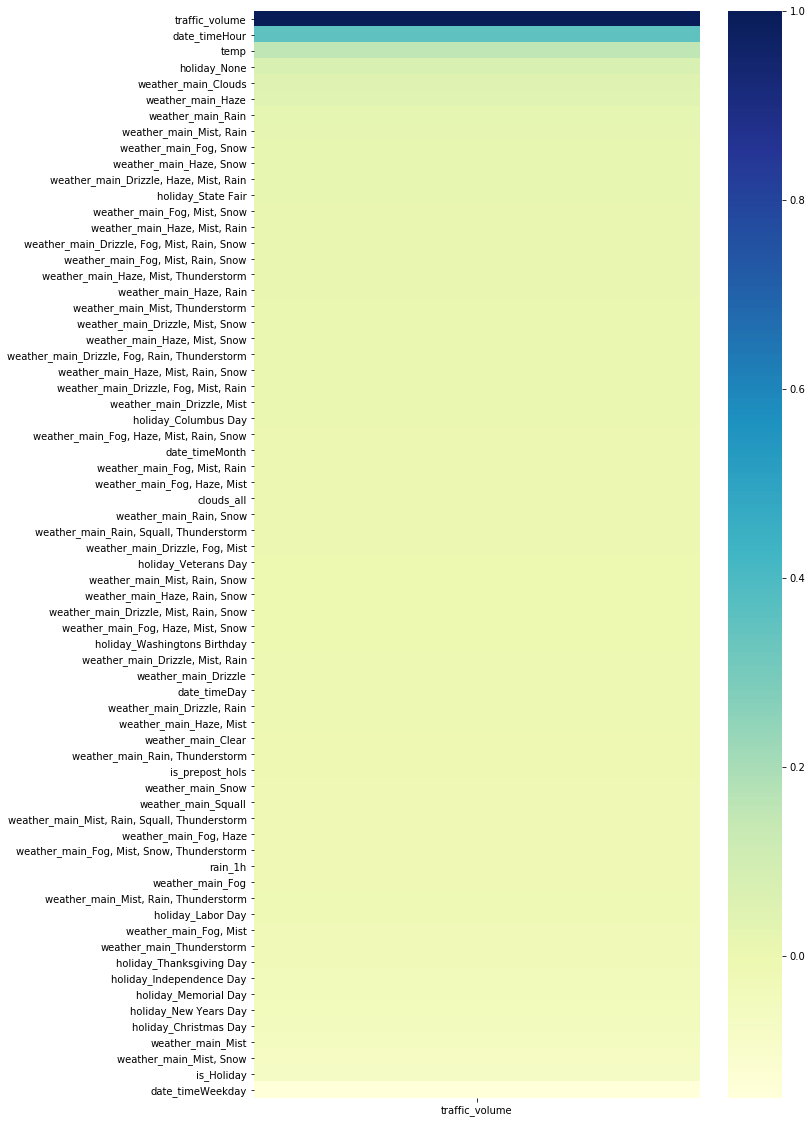

In [563]:
plt.figure(figsize=(10,20))
sns.heatmap(pd.DataFrame(df.corr()['traffic_volume']).sort_values(by = 'traffic_volume', ascending = False), cmap="YlGnBu")

#### Feature Importance

In [494]:
feat_imp = pd.DataFrame({'cols':X_train.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
feat_imp.head(20)

,cols,imp
5,date_timeHour,0.827036
6,date_timeWeekday,0.104198
2,temp,0.016379
7,is_Holiday,0.012241
62,holiday_None,0.009224
4,date_timeDay,0.008901
3,date_timeMonth,0.006491
8,is_prepost_hols,0.002903
0,clouds_all,0.002687
63,holiday_State Fair,0.001815


In [549]:
to_keep = feat_imp[feat_imp.imp>0.0002].cols; len(to_keep)

23

In [550]:
X_new = X[to_keep].copy()
y = df['traffic_volume']

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=10)

In [552]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [553]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

/Users/khalishahnadhirah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [554]:
print_score(model)

[172.9462252808179, 364.81110067715485, 0.9926134349046045, 0.9680856144028646]

Root Mean Squared Error of Predicted and Actual in on Training Set: 172.9462252808179
Root Mean Squared Error of Predicted and Actual in Validation Set: 364.81110067715485
R Squared score using Training Set: 0.9926134349046045
R Squared score using Validation Set: 0.9680856144028646


Feature Importance and Correaltion analysis did not help in model accuracy for validation set. Hence, we will revert to the base model.

### Parameter Tuning

In [564]:
X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [566]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [570]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/Users/khalishahnadhirah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[175.2544585661276, 345.0959517522176, 0.9924149489988568, 0.9714418462259914]

Root Mean Squared Error of Predicted and Actual in on Training Set: 175.2544585661276
Root Mean Squared Error of Predicted and Actual in Validation Set: 345.0959517522176
R Squared score using Training Set: 0.9924149489988568
R Squared score using Validation Set: 0.9714418462259914


#### - Increase number of trees

In [567]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[155.1338285068223, 351.51099920722703, 0.9940566216860546, 0.9703702329745071]

Root Mean Squared Error of Predicted and Actual in on Training Set: 155.1338285068223
Root Mean Squared Error of Predicted and Actual in Validation Set: 351.51099920722703
R Squared score using Training Set: 0.9940566216860546
R Squared score using Validation Set: 0.9703702329745071


In [574]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[147.2769579623972, 343.1560638126134, 0.9946433907781814, 0.9717620117269844]

Root Mean Squared Error of Predicted and Actual in on Training Set: 147.2769579623972
Root Mean Squared Error of Predicted and Actual in Validation Set: 343.1560638126134
R Squared score using Training Set: 0.9946433907781814
R Squared score using Validation Set: 0.9717620117269844


Introduction of 40 trees had improved in accuracy of model.

#### - Check for over fitting with out-of-bag score

In [573]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[147.95138082728317, 345.0586958996111, 0.994594219592253, 0.9714480120528053, 0.9621388798409196]

Root Mean Squared Error of Predicted and Actual in on Training Set: 147.95138082728317
Root Mean Squared Error of Predicted and Actual in Validation Set: 345.0586958996111
R Squared score using Training Set: 0.994594219592253
R Squared score using Validation Set: 0.9714480120528053


The model did not overfit, hence we will stick with the previous model.

In [575]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[148.5814713112353, 339.2548344716907, 0.9945480776267888, 0.9724004190120333]

Root Mean Squared Error of Predicted and Actual in on Training Set: 148.5814713112353
Root Mean Squared Error of Predicted and Actual in Validation Set: 339.2548344716907
R Squared score using Training Set: 0.9945480776267888
R Squared score using Validation Set: 0.9724004190120333


### Scoring

In [576]:
rmse(m.predict(X_test), y_test)

346.03682655182723

In [577]:
m.score(X_test, y_test)

0.9717052138526456

## (C) Final Modules

In [579]:
def data_prep():
    import pandas as pd, sys, re, datetime, time
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    from datetime import datetime, timedelta

    %matplotlib inline
    
    # Read data
    url = "https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv"
    df = pd.read_csv(url, parse_dates = ['date_time'])
    df.drop('snow_1h', axis = 1, inplace = True)
    
    # Fix weather_description
    df['weather_description'] = df['weather_description'].str.lower()
    
    # Get the repeated date_time values
    rep_date = pd.DataFrame(df['date_time'].value_counts()).reset_index()
    rep_date = pd.DataFrame(rep_date[rep_date['date_time'] > 1]['index'])
    rep_date.rename(columns = {'index': 'date_time'}, inplace = True)
    
    # To ensure concatenation of weather_main strings is done correctly, avoid duplicates
    df.sort_values(by = 'weather_main', inplace = True)
    df.reset_index(inplace = True, drop = True)
    
    # Concatenation of weather_main and weather_description
    df_rep = pd.merge(df, rep_date, how = 'inner', on = 'date_time')
    df_rep_wt_main = pd.DataFrame(df_rep.groupby(df_rep.columns.difference(['weather_main', 'weather_description']).tolist())['weather_main'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()
    df_rep_wt_desc = pd.DataFrame(df_rep.groupby('date_time')['weather_description'].apply(lambda x: "%s" % ', '.join(x.unique()))).reset_index()
    df_rep = pd.merge(df_rep_wt_main, df_rep_wt_desc, how = 'inner', on = 'date_time')
    
    # Remove the repeated rows of date_time
    df.drop_duplicates(subset =['date_time', 'traffic_volume'], keep = False, inplace = True)
    
    # Append the new cleaned rows of date_time
    df = df.append(df_rep, sort = True)
    
    # Extract date features from date_time
    def add_datepart(df, date_field, drop=False, time=False, errors="raise"):
        fld = df[date_field]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64
    
        if not np.issubdtype(fld_dtype, np.datetime64):
            df[date_field] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', date_field)
        attr = ['Month', 'Day', 'Hour', 'Date','Weekday']
        if time: 
            attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: 
            df[targ_pre + n] = getattr(fld.dt, n.lower())
        if drop: 
            df.drop(date_field, axis=1, inplace=True)
        
    add_datepart(df, 'date_time')
    
    # Fix Date data type
    df['date_timeDate'] =  pd.to_datetime(df['date_timeDate'], format='%Y-%m-%d')
    
    # Clean Holiday feature
    df_hols = df[df['holiday'] != 'None'][['holiday', 'date_timeDate']]

    df = pd.merge(df, df_hols, how = 'left', on = ['date_timeDate']).drop(columns = 'holiday_x')
    df.rename(columns = {'holiday_y': 'holiday'}, inplace = True)
    df['holiday'].fillna('None', inplace = True)

    df['is_Holiday'] = df['holiday'].apply(lambda x: 1 if x != 'None' else 0)

    df_holiday = df[df['is_Holiday'] == 1][['holiday', 'date_timeDate']].drop_duplicates()

    post = pd.DataFrame(df_holiday['date_timeDate'] + timedelta(days = 1))
    post['prepost_holiday'] = 'Post '+ df_holiday['holiday']
    post['is_prepost_hols'] = 2
    pre = pd.DataFrame(df_holiday['date_timeDate'] + timedelta(days = -1))
    pre['prepost_holiday'] = 'Pre '+ df_holiday['holiday']
    pre['is_prepost_hols'] = 1
    hols = pre.append(post, ignore_index = True)

    df = pd.merge(df, hols, how = 'left', on = ['date_timeDate'])
    df['prepost_holiday'].fillna('None', inplace = True)
    df['is_prepost_hols'].fillna(0, inplace = True)

    # Prepare Categorical Features - to be encoded

    df_cat = df[['date_time', 'weather_main', 'holiday']]
    df_cat_encoded = pd.get_dummies(df_cat)
    df = pd.merge(df, df_cat_encoded, how = 'inner', on = ['date_time'])

    # Drop Unecessary Features for final dataframe

    df.drop(columns = ['weather_main', 'weather_description', 'holiday', 'prepost_holiday', 'date_time', 'date_timeDate'], inplace = True)
    
    return df

In [583]:
def traffic_model(df):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import metrics
    import math
    
    # Get independent and dependent variable
    X = df.drop('traffic_volume', axis=1)
    y = df['traffic_volume']
    
    # Train-test_validation Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)
    
    # Metrics used to validate: RMSE
    def rmse(x,y): return math.sqrt(((x-y)**2).mean())
    
    # To print scores
    def print_score(m):
        res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                    m.score(X_train, y_train), m.score(X_valid, y_valid)]
        if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
        print('\nRoot Mean Squared Error of Predicted and Actual in on Training Set: '+ str(res[0]))
        print('Root Mean Squared Error of Predicted and Actual in Validation Set: '+ str(res[1]))
        print('R Squared score using Training Set: '+ str(res[2]))
        print('R Squared score using Validation Set: '+ str(res[3]))
    
    # Final model
    model = RandomForestRegressor(n_estimators=40, n_jobs=-1)
    model.fit(X_train, y_train)
    return print_score(model)

In [584]:
traffic_model(df)


Root Mean Squared Error of Predicted and Actual in on Training Set: 145.83969989344394
Root Mean Squared Error of Predicted and Actual in Validation Set: 340.3246110284922
R Squared score using Training Set: 0.9947474296442259
R Squared score using Validation Set: 0.9722260843638689
